In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import pprint
import os

matplotlib.rc('text', usetex=True)

# Load model and data

In [87]:
#model_idx, model_number = 'hd5-6294123123', 50 # Model with about 60% accuracy, compares good to baseline
#model_idx, model_number = 'hd5-8950268560', 25 # Graph Feature Model with about 61% accuracy, compares good to baseline
model_idx, model_number = 'hd5-9783975058', 2
#model_idx, model_number = 'hd5-7444815001', 2

In [88]:
config_path = f'training/{model_idx}/config.json'
with open('default_settings.json') as f:
        config = json.load(f)
with open(config_path) as f:
    util.dict_update(config, json.load(f))
data_train, data_val, data_test = util.dataset_from_config(config, filter_non_train=False, close_file=False)
model = util.model_from_config(config)

Classes [0 1]; Class counts [ 672760 1089606]
Reduced dataset to 672760 samples per class (1345520 / 1762366)


In [89]:
pprint.pprint(config)

{'dataset': {'balance_classes': True,
             'class_weights': 'balanced',
             'coordinates': ['COGCenteredVertexX',
                             'COGCenteredVertexY',
                             'COGCenteredVertexZ'],
             'currents': None,
             'distances_precomputed': False,
             'features': ['TimeFirstPulse',
                          'TimeLastPulse',
                          'TimeMaxPulse',
                          'TimeStd',
                          'ChargeFirstPulse',
                          'ChargeLastPulse',
                          'ChargeMaxPulse',
                          'COGCenteredVertexX',
                          'COGCenteredVertexY',
                          'COGCenteredVertexZ',
                          'VertexX',
                          'VertexY',
                          'VertexZ'],
             'flavors': None,
             'graph_features': ['RecoX',
                                'RecoY',
                     

In [90]:
#if torch.cuda.is_available():
#        model = model.cuda()
model.load_state_dict(torch.load(f'training/{model_idx}/model_{model_number}'))

<All keys matched successfully>

In [91]:
test_loader = DataLoader(data_test, batch_size=config['training']['batch_size'], shuffle=config['dataset']['shuffle'], collate_fn=data_test.collate, drop_last=False)

In [92]:
metrics = defaultdict(float)
y_pred = np.zeros(len(test_loader.dataset))
y_true = np.zeros(len(test_loader.dataset))
total_loss = 0
model.eval()
for batch_idx, (inputs, y_i, _) in enumerate(test_loader):
    print(f'\rEvaluating {batch_idx + 1} / {len(test_loader)}', end='\r')
    y_pred_i = model(*[i.cpu() for i in inputs])
    y_pred[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_pred_i.data.cpu().numpy().squeeze()
    y_true[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_i.data.cpu().numpy().squeeze()

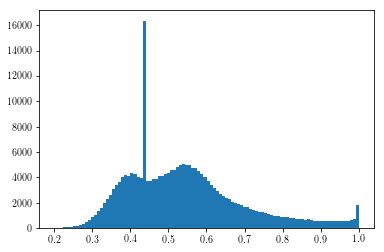

In [93]:
y_model = (y_pred >= .5).astype(np.int).flatten()
_ = plt.hist(y_pred, bins=100)

In [94]:
delta_llh = np.array(data_test.file['DeltaLLH'])[data_test._idxs]
y_baseline = (delta_llh >= 2.0).astype(np.uint8)

In [95]:
logits_model = y_pred
y_pred = (logits_model >= .5).astype(np.uint8)
acc_model = (y_pred == data_test.targets).sum() / y_pred.shape
acc_baseline = (y_baseline == data_test.targets).sum() / y_baseline.shape
acc_model, acc_baseline

(array([0.58557843]), array([0.61444881]))

# Check integrity of tracks in data

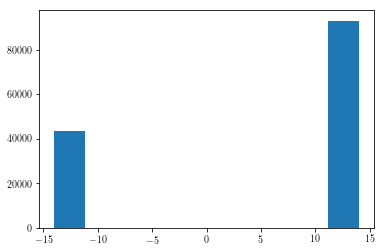

In [96]:
track_idx = data_test.targets > 0
_ = plt.hist(data_test.file['PDGEncoding'][track_idx])

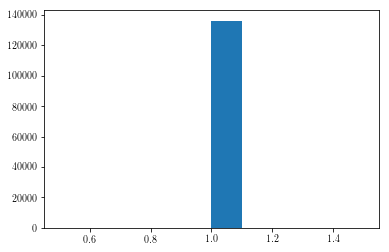

In [97]:
_ = plt.hist(data_test.file['InteractionType'][track_idx])

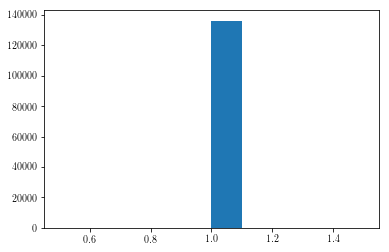

In [98]:
has_no_track_length = np.isnan(data_test.file['TrackLength'])
_ = plt.hist(data_test.targets[~has_no_track_length])

In [99]:
np.unique(data_test.file['PDGEncoding'][~has_no_track_length], return_counts=True)

(array([-14.,  14.]), array([43326, 92922]))

False

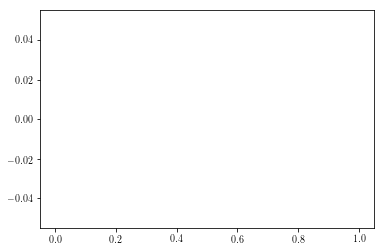

In [100]:
mask = (~np.isnan(data_test.file['TrackLength'])).copy()
mask[data_test.targets > 0] = False

track_lengths = data_test.file['TrackLength'][mask]
plt.hist(track_lengths, bins=200)

mask.any()

# Check Batchnorm of model

In [101]:
model.graph_convolutions[1].batchnorm.running_variance

tensor([2.4307, 0.9790, 1.3515, 1.1112, 1.3375, 3.7084, 1.6760, 0.5188, 4.3936,
        1.9877, 0.2943, 0.7861, 3.1684, 0.7742, 1.6228, 1.6262, 0.5262, 3.1838,
        2.5688, 1.9051, 0.6125, 2.6183, 0.3049, 4.5219, 1.8791, 2.5658, 1.3559,
        0.9483, 2.3521, 0.7962, 2.6444, 1.6477, 1.9341, 0.2672, 2.2773, 2.8684,
        1.7269, 0.8017, 1.1207, 1.3218, 0.4769, 2.2562, 0.2724, 0.0985, 0.3714,
        0.2850, 0.9203, 2.6295, 0.2096, 0.7209, 2.0235, 1.2585, 1.0748, 1.7414,
        4.8517, 1.3161, 1.7694, 0.2006, 2.2135, 4.1083, 0.7818, 0.7710, 1.8435,
        0.9949])

In [102]:
data_test.features.mean(0), data_test.features.std(0)

(array([ 6.16717558e-01,  6.75447944e-01,  6.33142512e-01,  2.45274318e-02,
         1.14877984e+00,  1.07118455e+00,  1.31084852e+00, -1.72397561e-04,
         4.53449570e-05,  1.04970250e-03, -2.62451001e-12, -2.03038639e-12,
        -3.23756173e-11]),
 array([0.50793224, 0.54240993, 0.51665181, 0.10815457, 0.94939857,
        0.49905676, 2.20266628, 0.0325995 , 0.03342982, 0.02795726,
        1.21162359, 1.19836402, 1.14504191]))

In [103]:
1 / model.kernel.inverse_sigma

tensor([0.1453], grad_fn=<MulBackward0>)

In [104]:
# Verify that batchnorm is working in testing mode
for X, y, _ in test_loader:
    break
y_pred1 = model(*[xi.cpu() for xi in X])
y_pred2 = model(*[xi[:32].cpu() for xi in X])
(y_pred1[:y_pred2.size(0)] == y_pred2).all()

tensor(True)

## Predict model on all data that was discarded during filtering

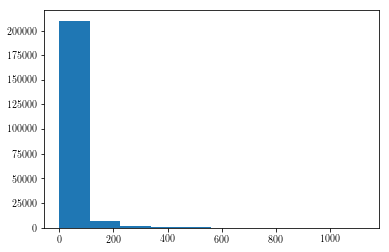

In [105]:
charge = np.array(data_test.file['TotalCharge'])[data_test._idxs]
pdg_encodings = np.array(data_test.file['PDGEncoding'])[data_test._idxs]
interaction_types = np.array(data_test.file['InteractionType'])[data_test._idxs]
muon_energy = np.array(data_test.file['MuonEnergy'])[data_test._idxs]
cascade_energy = np.array(data_test.file['CascadeEnergy'])[data_test._idxs]
# Fill NaNs with zeros
muon_energy[np.isnan(muon_energy)] = 0.0
cascade_energy[np.isnan(cascade_energy)] = 0.0
total_energy = muon_energy + cascade_energy
#_ = plt.hist(np.log(np.array(data_train.file['TotalCharge'])))
#plt.hist(charge)
_ = plt.hist(total_energy)

In [106]:
def binned_ppr(y_pred, y_gnd, values, number_bins=50, max_value=.1, min_value=50.0):
    """ Calculates the ppr binned in charges. 
    
    Parameters:
    -----------
    y_pred : ndarray, shape [N]
        Predictions.
    y_gnd : ndarray, shape [N]
        Ground truths.
    values : ndarray, shape [N]
        Values to be binned.
    number_bins : int, optional
        The number of bins.
    min_value : float, optional
        Minumum value for bins.
    max_value : float, optional
        Maximum value for bins.
    
    Returns:
    --------
    ppr : ndarray, shape [bins + 1]
        Positive predicted values for each bin.
    sigma_ppr : ndarray, shape [bins + 1]
        Uncertainty of predicted positive values for each bin.
    bins : ndarray, shape [bins]
        Bin edges.
    """
    log_values = np.log10(values)
    # Bin all charges
    bins = np.linspace(np.log10(min_value), np.log10(max_value), number_bins)
    
    bin_counts, _ = np.histogram(log_values, bins=bins)
    # Bin positive predictions
    pos_bin_counts, _ = np.histogram(log_values[y_pred > 0], bins=bins)
    ppr = pos_bin_counts / bin_counts
    
    # Calculate uncertainty
    sigma_bin_counts = np.sqrt(bin_counts)
    sigma_pos_bin_counts = np.sqrt(pos_bin_counts)
    
    sigma_ppr = np.sqrt(
        ppr**2 * ((sigma_bin_counts / bin_counts)**2 + (sigma_pos_bin_counts / pos_bin_counts)**2))
    return ppr, sigma_ppr, bins, pos_bin_counts, bin_counts

In [107]:
def ppr_plot(y_pred, y_gnd, charges, pdg_encodings, interaction_types, title, plots, 
             bins=50, xlabel='log(Integrated Charge) (pe)', min_charge=0.1, max_charge=50.0, filepath=None):
    """ Creates subplots for the ppr by neutrino flavour (and interaction type). """
    pgd_encodings = np.abs(pdg_encodings)
    fig = plt.figure(figsize=(15, 10))
    plt.xticks(fontsize=24)
    plt.xscale('log')
    
    for plot_label in plots:
        color, pdg_encoding, interaction_type = plots[plot_label]
        if interaction_type is None:
            mask = pdg_encodings == pdg_encoding
        else:
            mask = np.logical_and((pdg_encodings == pdg_encoding), (interaction_types == interaction_type))
                           
        ppr, sigma, bin_edges, _, _ = binned_ppr(y_pred[mask], y_gnd[mask], charges[mask], number_bins=bins, 
                                           min_value=min_charge, max_value=max_charge)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        plt.fill_between(
            np.power(10, bin_edges[1:]),
            ppr - sigma,
            ppr + sigma,
            color=color,
            alpha=.1,
            step='pre',
        )
        plt.errorbar(
            np.power(10, bin_edges[1:]),
            ppr,
            color=color,
            label=plot_label,
            linestyle='steps',
        )
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel('Positive Prediction Rate', fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylim(0, 1)
    #plt.legend(loc='left', bbox_to_anchor=(1.0, 1.0), fontsize=20)
    plt.legend(fontsize=24, loc='upper left')
    plt.title(title, fontsize=24)
    if filepath:
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        plt.savefig(filepath)

In [108]:
def ppr_plots(y_pred, y_baseline, y_gnd, charges, pdg_encodings, interaction_types, plots, 
             bins=50, xlabel='log(Integrated Charge) (pe)', min_charge=0.1, max_charge=50.0, filepath=None):
    """ Creates subplots for the ppr by neutrino flavour (and interaction type). """
    pgd_encodings = np.abs(pdg_encodings)
    fig = plt.figure(figsize=(20, 10))
    
    for idx, ys, title in ((1, y_pred, 'Model'), (2, y_baseline, 'Baseline')):
    
        plt.subplot(1, 2, idx)
        plt.xticks(fontsize=24)
        plt.xscale('log')

        for plot_label in plots:
            color, pdg_encoding, interaction_type = plots[plot_label]
            if interaction_type is None:
                mask = pdg_encodings == pdg_encoding
            else:
                mask = np.logical_and((pdg_encodings == pdg_encoding), (interaction_types == interaction_type))

            ppr, sigma, bin_edges, _, _ = binned_ppr(ys[mask], y_gnd[mask], charges[mask], number_bins=bins, 
                                               min_value=min_charge, max_value=max_charge)
            bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
            plt.fill_between(
                np.power(10, bin_edges[1:]),
                ppr - sigma,
                ppr + sigma,
                color=color,
                alpha=.1,
                step='pre',
            )
            plt.errorbar(
                np.power(10, bin_edges[1:]),
                ppr,
                color=color,
                label=plot_label,
                linestyle='steps',
            )
            
        plt.xlabel(xlabel, fontsize=24)
        plt.ylabel('Positive Prediction Rate', fontsize=24)
        plt.yticks(fontsize=24)
        plt.ylim(0, 1)
        plt.legend(fontsize=24, loc='upper left')
        plt.title(title)
    #plt.legend(loc='left', bbox_to_anchor=(1.0, 1.0), fontsize=20)
    if filepath:
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        #plt.gca().set_axis_off()
        #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
        #            hspace = 0, wspace = 0)
        #plt.margins(0,0)
        #plt.gca().xaxis.set_major_locator(plt.NullLocator())
        #plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(filepath, bbox_inches = 'tight',
            pad_inches = 0)

In [109]:
plots = {
    '$\\nu_e$ NC' : ('blue', 12, 2),
    '$\\nu_e$ CC' : ('black', 12, 1),
    '$\\nu_\\mu$ CC' : ('green', 14, 1),
    '$\\nu_\\mu$ NC' : ('red', 14, 2),
    #'nue' : ('blue', 12, None),
    #'nutau' : ('purple', 16, None),
    '$\\nu_\\tau$ NC' : ('grey', 16, 2),
    '$\\nu_\\tau$ CC' : ('brown', 16, 1)

}

In [111]:
import dataset
idx_filter = dataset.hd5.event_filter(data_test.file, min_track_length=70, max_cascade_energy=10)

After Track Length filter 136373 / 220295 events remain.
After Cascade Energy filter 119139 / 220295 events remain.


/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:178: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:184: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


In [112]:
(y_model[idx_filter] == data_test.targets[idx_filter]).sum() / idx_filter.sum()

0.6308345713830064

In [113]:
idx_filter.sum() / idx_filter.shape

array([0.54081572])

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


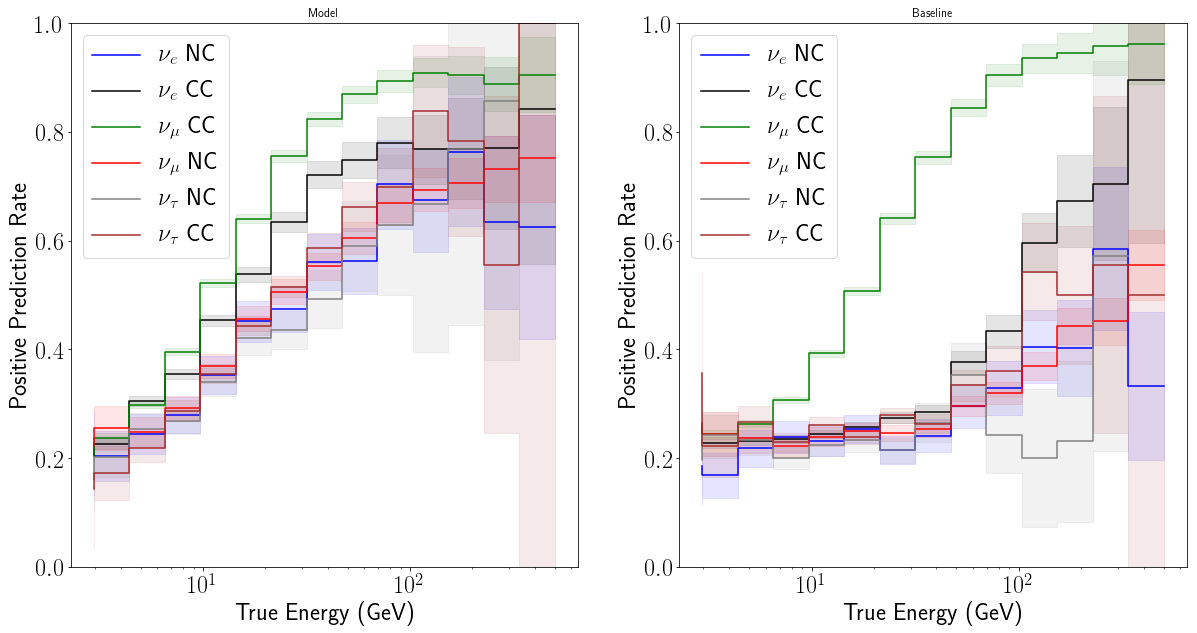

In [114]:
ppr_plots(y_model, y_baseline, data_test.targets, total_energy, pdg_encodings, interaction_types,
         plots, bins=15, min_charge=2.0, max_charge=500.0, xlabel='True Energy (GeV)', 
         filepath=os.path.join('.', 'plots', model_idx, 'ppr_all.pdf'))

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


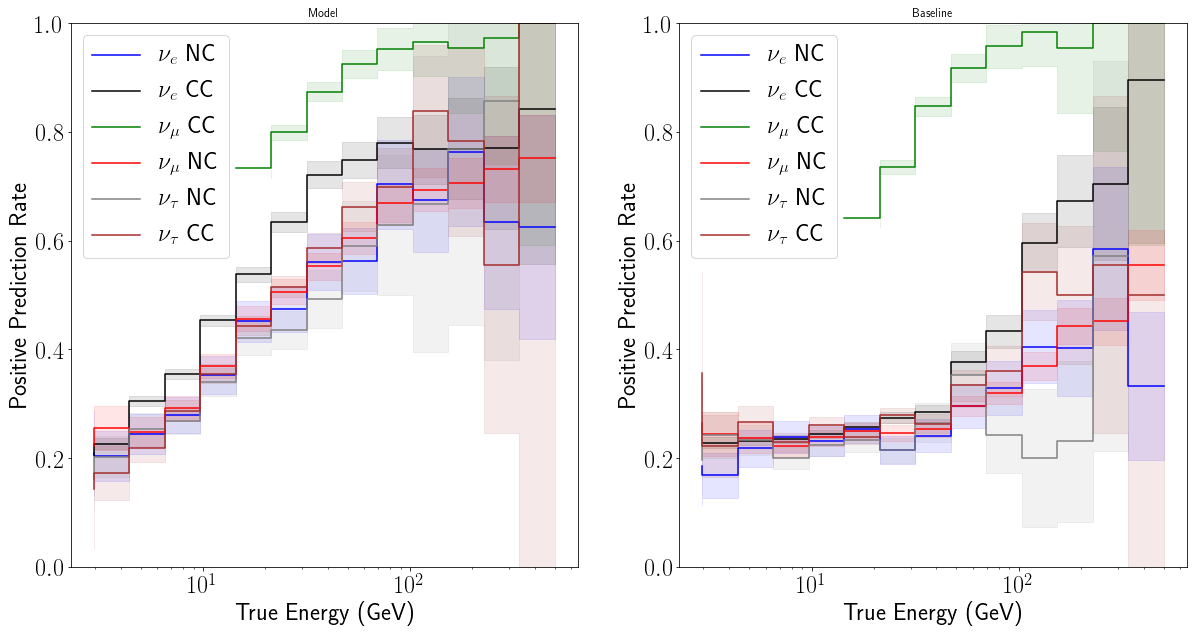

In [115]:
ppr_plots(y_model[idx_filter], y_baseline[idx_filter], data_test.targets[idx_filter], total_energy[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
         plots, bins=15, min_charge=2.0, max_charge=500.0, xlabel='True Energy (GeV)', 
         filepath=os.path.join('.', 'plots', model_idx, 'ppr_good_tracks.pdf'))

ppr_plot(y_model[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Model), "Good Tracks"', plots, bins=15)

ppr_plot(y_baseline[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Baseline), "Good Tracks"', plots, bins=15)

In [116]:
numucc = np.logical_and(interaction_types == 1, np.abs(pdg_encodings) == 14)
nuecc = np.logical_and(interaction_types == 1, np.abs(pdg_encodings) == 12)
y_model[numucc].sum() / y_model[numucc].shape, y_model[nuecc].sum() / y_model[nuecc].shape

(array([0.61201632]), array([0.44500492]))

In [117]:
numuecc = np.logical_or(numucc, nuecc)
y_model[numucc].sum() / y_model[numuecc].shape

array([0.45069616])

In [118]:
total_energy[interaction_types == 2].mean(), total_energy[interaction_types == 1].mean()

(61.241350528697005, 28.3755843497205)

(array([ 1052.,  6855., 23196., 43658., 51947., 42524., 26243., 14087.,
         6601.]),
 array([0.        , 0.25555556, 0.51111111, 0.76666667, 1.02222222,
        1.27777778, 1.53333333, 1.78888889, 2.04444444, 2.3       ]),
 <a list of 9 Patch objects>)

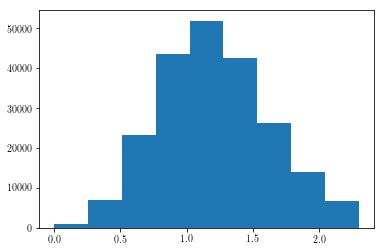

In [119]:
plt.hist(np.log10(total_energy), np.linspace(0, 2.3, 10)) 

# Correlation plots for trackness

In [120]:
data_test.file.keys()

<KeysViewHDF5 ['CMeans', 'COGCenteredCMeans', 'COGCenteredPrimaryX', 'COGCenteredPrimaryY', 'COGCenteredPrimaryZ', 'COGCenteredRecoX', 'COGCenteredRecoY', 'COGCenteredRecoZ', 'COGCenteredVertexX', 'COGCenteredVertexY', 'COGCenteredVertexZ', 'CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DCFiducialPE', 'DeltaLLH', 'EventID', 'InteractionType', 'MuonEnergy', 'NeutrinoEnergy', 'NoFlux', 'NuMuFlux', 'NueFlux', 'NumberChannels', 'NumberVertices', 'PDGEncoding', 'PrimaryAzimuth', 'PrimaryEnergy', 'PrimaryX', 'PrimaryXOriginal', 'PrimaryY', 'PrimaryYOriginal', 'PrimaryZ', 'PrimaryZOriginal', 'PrimaryZenith', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'RunID', 'TimeDeltaFirstPulse', 'TimeDeltaLastPulse', 'TimeDeltaMaxPulse', 'TimeDeltaStd', 'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeStd', 'TotalCharge', 'TrackLength', 'VertexX', 'VertexY', 'VertexZ']>

In [121]:
zenith_true = np.array(data_test.file['PrimaryZenith'])
zenith_reco = np.array(data_test.file['RecoZenith'])

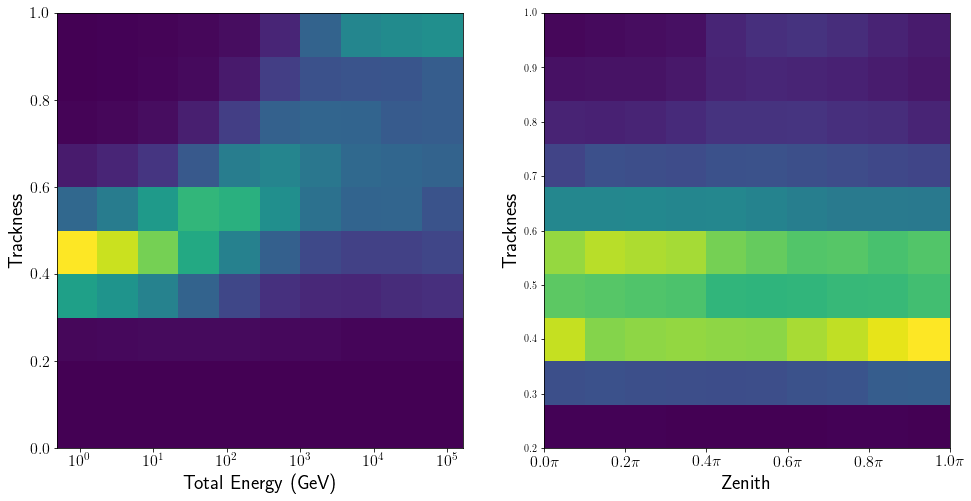

In [122]:
fig = plt.figure(figsize=(16,8))
# Correlation between log(energy) and trackness
plt.subplot(1, 2, 1)

y_bins = np.linspace(0, 1.0, 11)
x_bins = np.linspace(np.log(2), np.log(500), 11) # 2 to 500 GeV bins

counts, xedges, yedges = np.histogram2d(np.log(total_energy), logits_model, bins=(x_bins, y_bins))
counts /= counts.sum(1).reshape((-1, 1)) + 1e-20
plt.pcolor(xedges, yedges, counts.T)
plt.xlabel('Total Energy (GeV)', fontsize=20)
xticks, _ = plt.xticks()
plt.xticks(xticks[1:-1], labels=[f'$10^{int(tick)}$' for tick in xticks], fontsize=16)
#plt.xticks(xedges, fontsize=14)
plt.ylabel('Trackness', fontsize=20)
plt.yticks(fontsize=16)
# Correlation between zenith and trackness
plt.subplot(1, 2, 2)
counts, xedges, yedges = np.histogram2d(zenith_true, logits_model, bins=10)
counts /= counts.sum(1).reshape((-1, 1)) + 1e-20
plt.pcolor(xedges, yedges, counts.T)
plt.xlabel('Zenith', fontsize=20)
xticks = np.linspace(0, 1, 6)
plt.xticks(np.pi * xticks, labels=[f'${tick:.1f}\\pi$' for tick in xticks], fontsize=16)
plt.ylabel('Trackness', fontsize=20)

os.makedirs(os.path.join('.', 'plots', model_idx), exist_ok=True)
plt.savefig(os.path.join('.', 'plots', model_idx, 'corplot.pdf'))

